# Split characters in image

In [383]:
from typing import Text, List, Tuple, Optional
from numbers import Number

import os
from pathlib import Path

import numpy as np
import cv2
from scipy.signal import convolve

import matplotlib.pyplot as plt

%matplotlib inline

In [384]:
def normalize(data: np.array) -> np.array:
    return (data - data.min())/(data.max()-data.min())

def load_image(path: Text) -> np.array:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return normalize(image)

def show_image(image: np.array, keypoints: Optional[List[Tuple[Number]]] = None, title: Optional[Text] = "", figsize: Optional[Tuple[Number]] = (12,4)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    ax.imshow(image, cmap="gray")
    if keypoints:
        left_kp = [kp[0] for kp in keypoints]
        right_kp = [kp[1] for kp in keypoints]
        ax.vlines(x = left_kp, ymin=0, ymax=image.shape[0] - 1, color = 'r')
        ax.vlines(x = right_kp, ymin=0, ymax=image.shape[0] - 1, color = 'g')   
    plt.show()

def show_signal(signal: np.array, title: Optional[Text] = "", figsize: Optional[Tuple[Number]] = (12,4)) -> np.array:
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(signal)
    plt.show()

def image2signal(image: np.array) -> np.array:
    return image.mean(axis=0)

def binarize_signal(signal: np.array,  threshold = 0.9) -> np.array:
    return (signal > threshold).astype(np.uint8)

def get_crop_keypoints(signal: np.array) -> List[Tuple[Number]]:
    kernel_left = [-1, 1]
    kernel_right = [1, -1]
    signal_diff_left = convolve(signal, kernel_left)
    signal_diff_right = convolve(signal, kernel_right)

    # 8 keypoints to detect 7 elements
    # filter extreme points
    kp = 8
    left_kp = np.argpartition(signal_diff_left, -kp)[-kp:]
    left_kp = sorted(left_kp)[:-1]
    right_kp = np.argpartition(signal_diff_right, -kp)[-kp:]
    right_kp = sorted(right_kp)[1:]

    return list(map(lambda x: tuple(x), zip(left_kp, right_kp)))

def get_cropped_images(image: np.array, crop_keypoints: List[Tuple[Number]]) -> List[np.array]:
    return [image[:, kp[0]:kp[1]] for kp in crop_keypoints]  

def get_characters_from_plate(image: np.array, threshold = 0.9) -> List[np.array]:
    raw_signal = image2signal(image)
    binary_signal = binarize_signal(raw_signal, threshold)
    crop_kp = get_crop_keypoints(binary_signal)
    character_image_list = get_cropped_images(image, crop_kp)
    return character_image_list


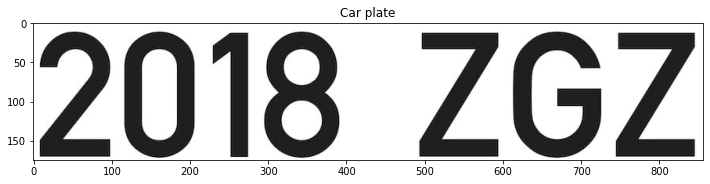

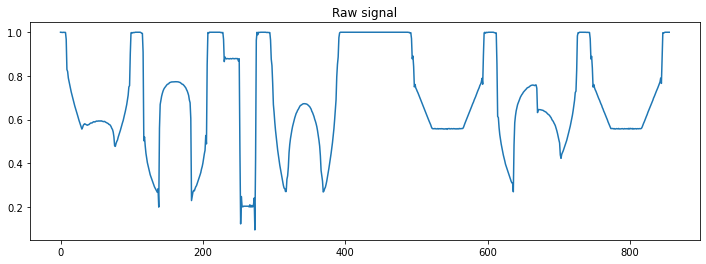

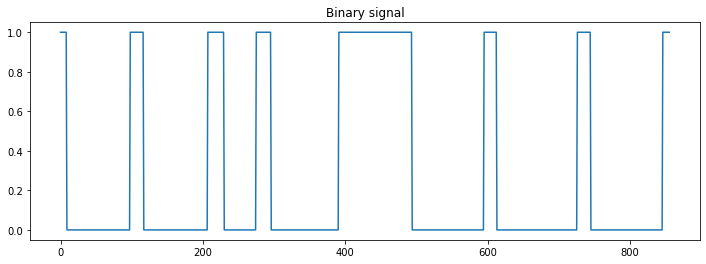

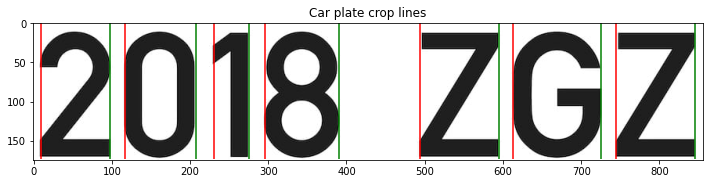

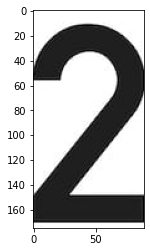

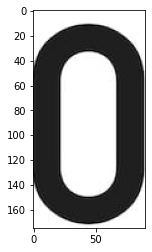

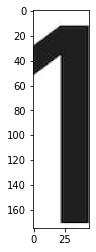

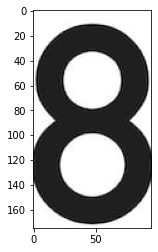

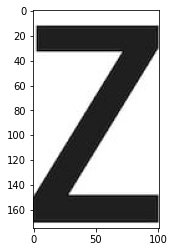

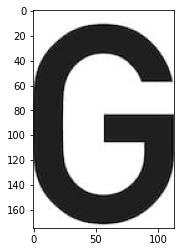

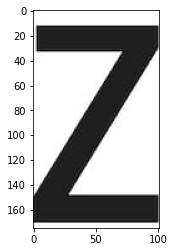

In [385]:
def main():
    image_path = Path("images/segmentation/2018_zgz_segmentation_test.png")
    image = load_image(image_path)
    show_image(image, title="Car plate")
    raw_signal = image2signal(image)
    binary_signal = binarize_signal(raw_signal)
    show_signal(raw_signal, "Raw signal")
    show_signal(binary_signal, "Binary signal")
    crop_kp = get_crop_keypoints(binary_signal)
    show_image(image, keypoints=crop_kp, title="Car plate crop lines")
    character_image_list = get_cropped_images(image, crop_kp)
    for char_image in character_image_list:
        show_image(char_image, figsize=(6,4))

main()

# OCR model

## First idea - Use car plate dataset to train ocr model

In [386]:
import pandas as pd

import xml.etree.ElementTree as ET
from tqdm import tqdm

In [387]:
filenames = []
images = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [388]:
images_path = 'images/ocr/archive/images/'
annotations_path = 'images/ocr/archive/annotations/'
images_list = sorted(os.listdir(images_path))
annotations_list = sorted(os.listdir(annotations_path))
for file, image_file in tqdm(zip(annotations_list, images_list)):
    images.append(os.path.join(images_path, image_file))
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

433it [00:00, 10725.47it/s]


In [389]:
df = pd.DataFrame({
    'file':filenames,
    'image':images,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [390]:
df.head()

,file,image,width,height,xmin,ymin,xmax,ymax
0,images/ocr/archive/annotations/Cars0.xml,images/ocr/archive/images/Cars0.png,500,268,226,125,419,173
1,images/ocr/archive/annotations/Cars1.xml,images/ocr/archive/images/Cars1.png,400,248,134,128,262,160
2,images/ocr/archive/annotations/Cars10.xml,images/ocr/archive/images/Cars10.png,400,225,140,5,303,148
3,images/ocr/archive/annotations/Cars100.xml,images/ocr/archive/images/Cars100.png,400,267,175,114,214,131
4,images/ocr/archive/annotations/Cars101.xml,images/ocr/archive/images/Cars101.png,400,300,167,202,240,220


In [391]:
df[["xmin", "ymin", "xmax", "ymax"]].values

array([[226, 125, 419, 173],
       [134, 128, 262, 160],
       [140,   5, 303, 148],
       ...,
       [ 98, 102, 297, 191],
       [ 85, 196, 247, 259],
       [ 70, 198, 262, 271]])

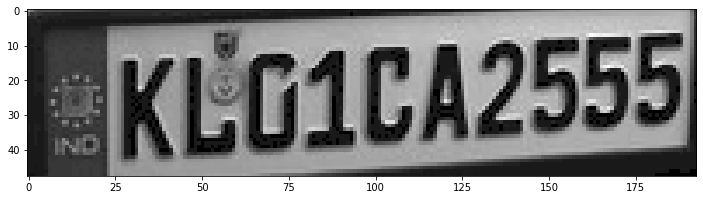

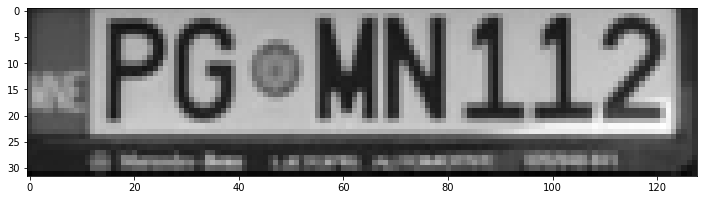

In [395]:
n_break = 1
for image_file, (xmin, ymin, xmax, ymax) in zip(df["image"].values, df[["xmin", "ymin", "xmax", "ymax"]].values):
    image = load_image(image_file)
    crop_image = image[ymin:ymax, xmin:xmax]
    show_image(crop_image)
    n_break += 1
    if n_break > 2:
        break

In [396]:
char_img = get_characters_from_plate(crop_image)

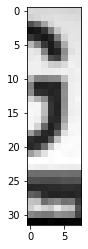

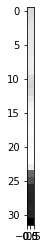

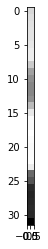

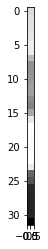

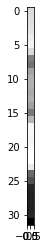

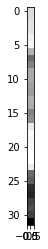

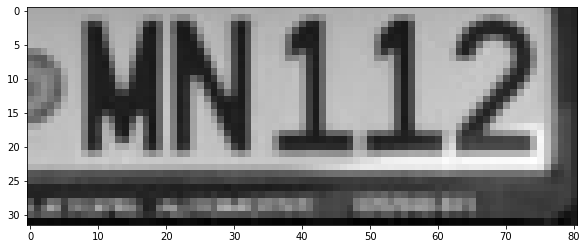

In [397]:
character_image_list = get_characters_from_plate(crop_image)
for char_image in character_image_list:
    show_image(char_image)

## Second idea - Use EMNIST dataset and cluster